# Tuần 3: Sử dụng RNN để dự đoán chuỗi thời gian

Chào mừng! Trong bài tập trước, bạn đã sử dụng mạng nơ-ron sâu đơn giản để tạo dự báo cho chuỗi thời gian được tạo. Lần này bạn sẽ sử dụng các lớp của Tensorflow để xử lý dữ liệu chuỗi, chẳng hạn như các lớp Lặp lại hoặc LSTM để xem hai cách tiếp cận này so sánh như thế nào.

Bắt đầu nào!

_**LƯU Ý:** Để tránh lỗi từ hệ thống tự động chấm, bạn không được phép chỉnh sửa hoặc xóa một số ô trong sổ tay này. Vui lòng chỉ đặt giải pháp của bạn ở giữa nhận xét mã `### BẮT ĐẦU MÃ TẠI ĐÂY` và `### KẾT THÚC MÃ KẾT THÚC TẠI ĐÂY`, đồng thời không thêm bất kỳ ô mới nào. **Khi bạn đã vượt qua bài tập này** và muốn thử nghiệm với bất kỳ ô nào bị khóa, bạn có thể làm theo hướng dẫn ở cuối sổ ghi chép này._

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

## Tạo dữ liệu

Ô tiếp theo bao gồm một loạt các hàm trợ giúp để tạo và vẽ biểu đồ chuỗi thời gian:

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """An arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

Bạn sẽ tạo dữ liệu chuỗi thời gian giống như trong bài tập tuần trước.

**Lưu ý rằng lần này tất cả việc tạo được thực hiện trong một hàm và các biến toàn cục được lưu trong một lớp dữ liệu. Điều này được thực hiện để tránh sử dụng phạm vi toàn cục như đã được thực hiện trong tuần đầu tiên của khóa học.**

Nếu trước đây bạn chưa từng sử dụng các lớp dữ liệu thì chúng chỉ là các lớp Python cung cấp cú pháp thuận tiện để lưu trữ dữ liệu. Bạn có thể đọc thêm về chúng trong [docs](https://docs.python.org/3/library/dataclasses.html).



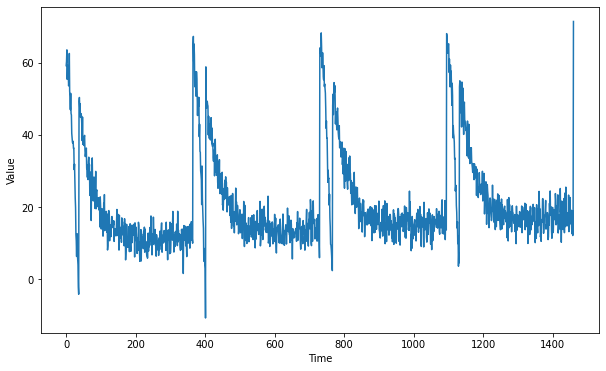

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Xử lý dữ liệu

Vì bạn đã mã hóa các hàm `train_val_split` và `windowed_dataset` trong các bài tập của tuần trước nên lần này chúng được cung cấp cho bạn:



In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

## Xác định kiến ​​trúc mô hình

Bây giờ bạn đã có một hàm sẽ xử lý dữ liệu trước khi dữ liệu được đưa vào mạng thần kinh của bạn để huấn luyện, đã đến lúc xác định kiến ​​trúc lớp của bạn. Không giống như các tuần hoặc khóa học trước mà bạn xác định các lớp của mình và biên dịch mô hình theo cùng một hàm, ở đây trước tiên bạn cần phải hoàn thành hàm `create_uncompiled_model` bên dưới.

Điều này được thực hiện để bạn có thể sử dụng lại các lớp của mô hình để điều chỉnh tốc độ học tập và đào tạo thực tế.

Gợi ý:
- Điền vào các lớp `Lambda` ở đầu và cuối mạng với các chức năng lamda chính xác.
- Bạn nên sử dụng `SimpleRNN` hoặc `Bidirectional(LSTM)` làm lớp trung gian.
- Lớp cuối cùng của mạng (trước `Lambda` cuối cùng) phải là lớp `Dense`.

In [6]:
def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
    ]) 
    
    ### END CODE HERE

    return model

In [7]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Your current architecture is compatible with the windowed dataset! :)


## Điều chỉnh tốc độ học - (Bài tập tùy chọn)

Như bạn đã thấy trong bài giảng, bạn có thể tận dụng các lệnh gọi lại của Tensorflow để thay đổi tốc độ học tập trong quá trình đào tạo một cách linh hoạt. Điều này có thể hữu ích để hiểu rõ hơn về tốc độ học tập nào phù hợp hơn với vấn đề hiện tại.

**Lưu ý rằng điều này chỉ thay đổi tốc độ học trong quá trình đào tạo để giúp bạn biết thế nào là tốc độ học hợp lý và không nên nhầm lẫn với việc chọn tốc độ học tốt nhất, điều này được gọi là tối ưu hóa siêu tham số và nó nằm ngoài phạm vi phạm vi của khóa học này.**

Đối với trình tối ưu hóa, bạn có thể thử:
- [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
- [`tf.keras.optimizers.SGD`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) với động lượng 0,9

In [8]:
def adjust_learning_rate():
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [9]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 [==============================] - 7s 62ms/step - loss: 28.0870 - mae: 28.5838 - lr: 1.0000e-06
Epoch 2/100
34/34 [==============================] - 2s 50ms/step - loss: 7.0847 - mae: 7.5665 - lr: 1.1220e-06
Epoch 3/100
34/34 [==============================] - 2s 51ms/step - loss: 5.1110 - mae: 5.5855 - lr: 1.2589e-06
Epoch 4/100
34/34 [==============================] - 2s 54ms/step - loss: 4.6096 - mae: 5.0773 - lr: 1.4125e-06
Epoch 5/100
34/34 [==============================] - 2s 55ms/step - loss: 4.6740 - mae: 5.1441 - lr: 1.5849e-06
Epoch 6/100
34/34 [==============================] - 2s 50ms/step - loss: 4.2310 - mae: 4.7008 - lr: 1.7783e-06
Epoch 7/100
34/34 [==============================] - 2s 48ms/step - loss: 3.8743 - mae: 4.3404 - lr: 1.9953e-06
Epoch 8/100
34/34 [==============================] - 2s 53ms/step - loss: 3.7739 - mae: 4.2349 - lr: 2.2387e-06
Epoch 9/100
34/34 [==============================] - 2s 53ms/step - loss: 3.6061 - mae: 4.0722 - lr: 2

(1e-06, 1.0, 0.0, 30.0)

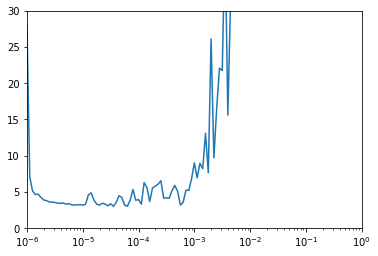

In [10]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

## Biên dịch mô hình

Bây giờ bạn đã huấn luyện mô hình trong khi thay đổi tốc độ học, đã đến lúc thực hiện huấn luyện thực tế sẽ được sử dụng để dự báo chuỗi thời gian. Để làm điều này, hãy hoàn thành hàm `create_model` bên dưới.

Lưu ý rằng bạn đang sử dụng lại kiến ​​trúc mà bạn đã xác định trong `create_uncompiled_model` trước đó. Bây giờ bạn chỉ cần biên dịch mô hình này bằng cách sử dụng mức mất, trình tối ưu hóa (và tốc độ học tập) thích hợp.

Gợi ý:
- Quá trình đào tạo phải thực sự nhanh chóng, vì vậy nếu bạn nhận thấy rằng mỗi kỷ nguyên mất hơn vài giây, hãy cân nhắc thử một kiến ​​trúc khác.


- Nếu sau kỷ nguyên đầu tiên bạn nhận được kết quả đầu ra như thế này: `loss: nan - mae: nan` thì rất có thể mạng của bạn đang bị bùng nổ độ dốc. Đây là sự cố thường gặp nếu bạn sử dụng `SGD` làm trình tối ưu hóa và đặt tốc độ học tập quá cao. **Nếu bạn gặp phải vấn đề này, hãy cân nhắc việc giảm tốc độ học tập hoặc sử dụng Adam với tốc độ học tập mặc định.**

In [13]:
def create_model():

    tf.random.set_seed(51)
    
    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["mae"])  
    
    ### END CODE HERE

    return model

In [14]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(dataset, epochs=50)

Epoch 1/50
34/34 [==============================] - 7s 63ms/step - loss: 10.1431 - mae: 10.6246
Epoch 2/50
34/34 [==============================] - 2s 49ms/step - loss: 4.3360 - mae: 4.7999
Epoch 3/50
34/34 [==============================] - 2s 47ms/step - loss: 3.4668 - mae: 3.9328
Epoch 4/50
34/34 [==============================] - 2s 54ms/step - loss: 3.2548 - mae: 3.7227
Epoch 5/50
34/34 [==============================] - 2s 53ms/step - loss: 2.8491 - mae: 3.3103
Epoch 6/50
34/34 [==============================] - 2s 52ms/step - loss: 2.7638 - mae: 3.2221
Epoch 7/50
34/34 [==============================] - 2s 57ms/step - loss: 3.1033 - mae: 3.5694
Epoch 8/50
34/34 [==============================] - 2s 52ms/step - loss: 2.9994 - mae: 3.4622
Epoch 9/50
34/34 [==============================] - 2s 49ms/step - loss: 2.6716 - mae: 3.1325
Epoch 10/50
34/34 [==============================] - 2s 58ms/step - loss: 2.7049 - mae: 3.1700
Epoch 11/50
34/34 [==============================] - 2s 5

##Đánh giá dự báo

Bây giờ là lúc đánh giá hiệu quả của dự báo. Để làm điều này, bạn có thể sử dụng hàm `compute_metrics` mà bạn đã mã hóa trong bài tập trước:

In [15]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

Tại thời điểm này, chỉ có mô hình thực hiện dự báo đã sẵn sàng nhưng bạn vẫn cần tính toán dự báo thực tế.

## Dự báo mô hình nhanh hơn

Trong tuần trước, bạn đã sử dụng vòng lặp for để tính toán dự báo cho mọi điểm trong chuỗi. Cách tiếp cận này hợp lệ nhưng có một cách hiệu quả hơn để thực hiện điều tương tự bằng cách sử dụng các lô dữ liệu. Mã để triển khai điều này được cung cấp trong `model_forecast` bên dưới. Lưu ý rằng mã này rất giống với mã trong hàm `windowed_dataset` với những điểm khác biệt:

- Tập dữ liệu được tạo cửa sổ bằng `window_size` thay vì `window_size + 1`
- Không nên sử dụng shuffle
- Không cần chia dữ liệu thành các tính năng và nhãn
- Một mô hình được sử dụng để dự đoán các lô của tập dữ liệu

In [16]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

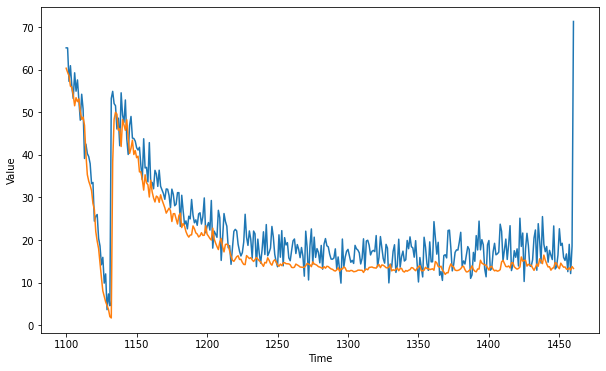

In [17]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

**Đầu ra dự kiến:**

Một loạt tương tự như thế này:

<div>
<img src="images/expected.png" width="500"/>
</div>

In [18]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 40.19, mae: 4.26 for forecast


**Để vượt qua nhiệm vụ này, dự báo của bạn phải đạt được MAE từ 4,5 trở xuống.**

- Nếu dự báo của bạn không đạt được ngưỡng này, hãy thử đào tạo lại mô hình của bạn với kiến ​​trúc khác (bạn sẽ cần chạy lại cả hai hàm `create_uncompiled_model` và `create_model`) hoặc điều chỉnh các tham số của trình tối ưu hóa.


- Nếu dự báo của bạn đã đạt được ngưỡng này, hãy chạy ô sau để lưu mô hình của bạn vào tệp `tar`. Tệp này sẽ được sử dụng để chấm điểm và sau khi làm như vậy, hãy gửi bài tập của bạn để chấm điểm.


- Môi trường này bao gồm một thư mục `SavedModel` giả chứa mô hình giả được huấn luyện cho một kỷ nguyên. **Để thay thế tệp này bằng mô hình thực tế của bạn, bạn cần chạy ô tiếp theo trước khi gửi để chấm điểm.**


- Không giống như tuần trước, lần này mô hình được lưu bằng định dạng `SavedModel`. Điều này được thực hiện vì định dạng HDF5 không hỗ trợ đầy đủ các lớp `Lambda`.

In [19]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


saved_model/
saved_model/my_model/
saved_model/my_model/keras_metadata.pb
saved_model/my_model/variables/
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/variables/variables.index
saved_model/my_model/saved_model.pb
saved_model/my_model/assets/


**Chúc mừng bạn đã hoàn thành bài tập tuần này!**

Bạn đã triển khai thành công mạng thần kinh có khả năng dự báo chuỗi thời gian tận dụng các lớp của Tensorflow để lập mô hình chuỗi như `RNNs` và `LSTMs`! **Điều này dẫn đến kết quả dự báo khớp (hoặc thậm chí vượt qua) dự báo từ tuần trước khi tập luyện trong một nửa thời gian.**

**Cố lên!**

<chi tiết>
<summary><font size="2" color="darkgreen"><b>Vui lòng nhấp vào đây nếu bạn muốn thử nghiệm bất kỳ mã nào không được phân loại.</b></font></summary>
<p><i><b>Lưu ý quan trọng: Vui lòng chỉ thực hiện việc này khi bạn đã vượt qua bài tập để tránh sự cố với hệ thống tự động chấm điểm.</b></i>
<ol>
<li> Trên menu của sổ ghi chép, hãy nhấp vào “Xem” > “Thanh công cụ di động” > “Chỉnh sửa siêu dữ liệu”</li>
<li> Nhấn nút “Chỉnh sửa siêu dữ liệu” bên cạnh ô mã mà bạn muốn khóa/mở khóa</li>
<li> Đặt giá trị thuộc tính cho “có thể chỉnh sửa” thành:
<ul>
<li> “đúng” nếu bạn muốn mở khóa </li>
<li> “false” nếu bạn muốn khóa nó </li>
</ul>
</li>
<li> Trên menu của sổ ghi chép, hãy nhấp vào “Xem” > “Thanh công cụ di động” > “Không có” </li>
</ol>
<p> Dưới đây là bản demo ngắn về cách thực hiện các bước trên:
<br>
<img src="https://drive.google.com/uc?export=view&id=14Xy_Mb17CZVgzVAgq7NCjMVBvSae3xO1"align="center">
</ chi tiết>